In [1]:
import torch
import numpy as np
import random

def make_determenistic_or_random(seed):
    """
    based on seed makes everything random or determenistic. Any other than None are for determenistic
    """
    # I still need to keep in mind sklearn random_state
    random.seed(seed)
    torch.manual_seed(seed if seed != None else torch.seed())
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed if seed != None else torch.seed())
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True if seed!=None else False
    torch.backends.cudnn.benchmark = False if seed!=None else True

make_determenistic_or_random(0)

In [2]:
import pandas as pd
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import os
from skimage.io import imread, imsave
from skimage.color import rgb2gray, rgba2rgb, gray2rgb
import pytorch_lightning as pl

# data preparation

In [3]:
ds_root = '/home/alexander/work/hackathon/chest-14/images/'
ds_root_MED = './DATASET_MED/'

In [4]:
test_img = imread("/home/alexander/work/hackathon/DATASET_MED/2000000.png")
print(test_img.dtype, test_img.min(), test_img.max())

uint8 0 252


In [5]:
test_img = imread('/mercurySOFS/Medical/NIH/images/00000001_000.png')
print(test_img.dtype, test_img.min(), test_img.max())

uint8 0 255


In [6]:
df_med = pd.read_csv('./Only_labels.csv')

In [7]:
df_only_labels = pd.read_csv('/home/alexander/work/hackathon/chest-14/Data_Entry_2017.csv')
df_only_labels

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168


extracting all possible pathologies from dataset labels

In [8]:
'asd'.split('|')

['asd']

In [9]:
from functools import reduce 
pathologies = sorted(list(reduce(lambda acc, str: set(str.split('|')).union(set(acc)),df_only_labels['Finding Labels'].unique(), set([]))))
del pathologies[-5]
pathologies

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

check how to predict labels

In [10]:
labels = []
for pathology in pathologies:
    labels.append(df_only_labels['Finding Labels'].str.contains(pathology).values)

labels = np.asarray(labels).T
labels = labels.astype(int)

labels

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
# new_df = pd.DataFrame(columns=['Name',
#                                'Atelectasis',
#                                  'Cardiomegaly',
#                                  'Consolidation',
#                                  'Edema',
#                                  'Effusion',
#                                  'Emphysema',
#                                  'Fibrosis',
#                                  'Hernia',
#                                  'Infiltration',
#                                  'Mass',
#                                  'Nodule',
#                                  'Pleural_Thickening',
#                                  'Pneumonia',
#                                  'Pneumothorax'])

# new_df['Name'] = df_only_labels[0]
# for i, item in enumerate(pathologies):
#     new_df[item]=labels[:,i]

# new_df.reset_index(drop=True).to_csv('labels.csv', index=False)

In [12]:
labels[-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Creating model with pre-trained weights

lets create a dataset class so that we can load it to dataloader

In [13]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, csv, path_to_root, pathologies, aug = None, tr=None):
        super(Dataset, self).__init__()
        
        self.path_to_root = path_to_root
        self.csv = csv
        self.pathologies = pathologies
        self.aug = aug
        self.tr = tr
        
        self.labels = []
        for pathology in self.pathologies:
            self.labels.append(self.csv['Finding Labels'].str.contains(pathology).values)
            
        self.labels = np.asarray(self.labels).T
        self.labels = self.labels.astype(np.float32)
        
    def __getitem__(self, idx):
        item = self.csv.iloc[idx]
        
        img = imread(os.path.join(self.path_to_root,item['Image Index']))
        if img.ndim==3:
            if img.shape[2]==4:
                img = rgb2gray(rgba2rgb(img))
            else:
                img = rgb2gray(img)
        if 'float' in str(img.dtype):
            img = (img*255).astype(np.uint8)
        img = np.expand_dims(img,-1)
        label = self.labels[idx]
        
        if self.tr:
            img = self.tr(image=img)['image']
        if self.aug:
            img = self.aug(image=img)['image']
            
        sample = {"image": img, 'label': label}
            
        return sample
    
    def __len__(self):
        return len(self.csv)

uint8 255 0
uint8 254 0
uint8 255 3
uint8 252 0
uint8 255 0
uint8 255 6
uint8 255 0
uint8 255 0
uint8 255 0
uint8 255 0
uint8 248 0
uint8 247 0
uint8 255 0
uint8 255 0
uint8 255 0
uint8 255 0
uint8 249 0
uint8 251 0
uint8 251 0
uint8 249 0
uint8 255 0
uint8 255 0
uint8 255 0
uint8 246 9
uint8 252 0


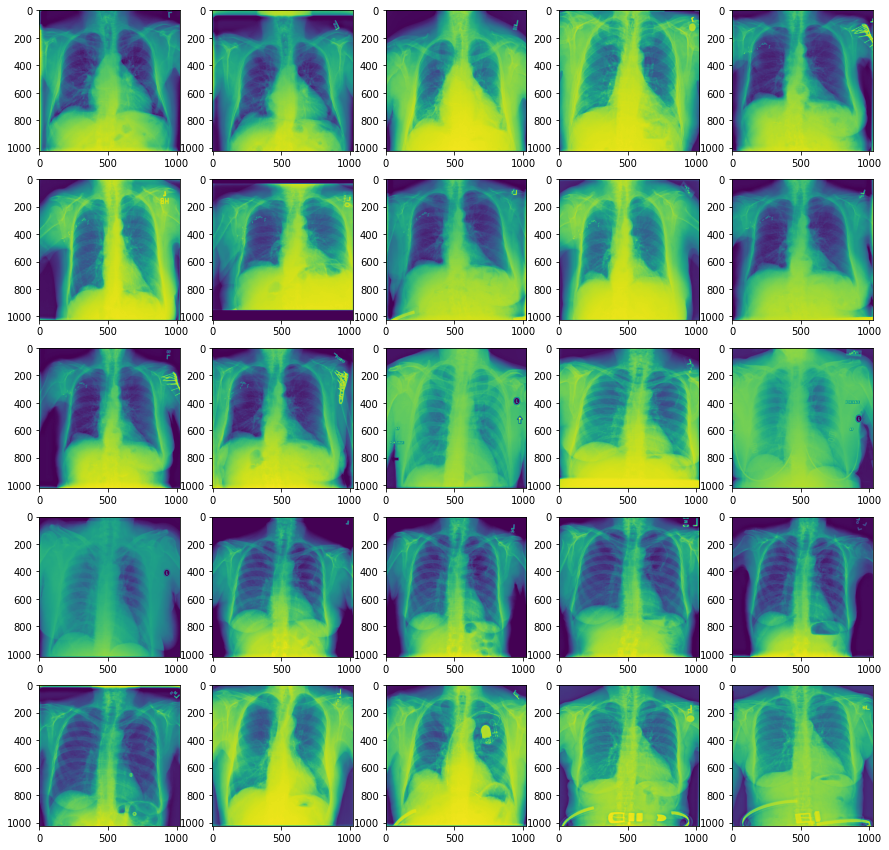

In [14]:
ds = MyDataset(df_only_labels, ds_root, pathologies = pathologies)

rows = 5
cols = 5

fig = plt.figure(figsize=(rows*3, cols*3))
for i in range(rows*cols):
    fig.add_subplot(rows,cols,i+1)
    img = ds[i]['image']
    print(img.dtype, img.max(), img.min())
    plt.imshow(img)
plt.show()

In [15]:
ds.labels.shape

(112120, 14)

In [16]:
from albumentations.core.composition import *
from albumentations.pytorch import ToTensor, ToTensorV2
from albumentations.augmentations.transforms import *

def normalizer(img, **params):
    img = img.astype(np.float32)
    if img.max()>255:
        img/=65535.
    elif img.max()>1:
        img/=255.
    return (img-0.5)*2
        

def center_crop(img, **params):
        x,y,_ = img.shape
        crop_size = np.min([y,x])
        startx = x // 2 - (crop_size // 2)
        starty = y // 2 - (crop_size // 2)
        return img[startx:startx + crop_size, starty:starty + crop_size, :]
    
tr = Compose([Lambda(image=normalizer), Resize(224, 224), ToTensorV2()])
transform = Compose([OneOf([GaussNoise(),Blur(blur_limit=7,p=0.1)], p=0.7),HorizontalFlip(p=0.5)
         ,ShiftScaleRotate(shift_limit=0.2,scale_limit=0.15,rotate_limit=20,interpolation=1,p=1,border_mode=4)
         ,OneOf([RandomBrightnessContrast(brightness_limit=0.3,contrast_limit=0.3), RandomGamma()],p=0.8)])


In [17]:
ds_med = MyDataset(df_med, ds_root_MED, pathologies = pathologies, aug = tr)

In [18]:
ds = MyDataset(df_only_labels, ds_root, pathologies = pathologies, aug = tr, tr = transform)
ds[0]

{'image': tensor([[[-0.6317, -0.6437, -0.6492,  ..., -0.6863, -0.6863, -0.6863],
          [-0.5977, -0.6028, -0.6286,  ..., -0.6863, -0.6863, -0.6863],
          [-0.5679, -0.5873, -0.5854,  ..., -0.6863, -0.6863, -0.6863],
          ...,
          [ 0.5156,  0.5124,  0.4845,  ...,  0.5535,  0.5244,  0.5052],
          [ 0.5087,  0.5157,  0.5016,  ...,  0.5421,  0.5640,  0.5255],
          [ 0.5107,  0.5008,  0.4752,  ...,  0.5496,  0.5415,  0.5303]]]),
 'label': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)}

In [19]:
from sklearn.model_selection import train_test_split

train,val = train_test_split(df_only_labels, stratify=(df_only_labels['Finding Labels']=='No Finding').values, test_size=0.3)

In [20]:
train

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
49247,00012490_000.png,No Finding,0,12490,51,M,PA,2500,2048,0.168,0.168
76561,00018816_000.png,Atelectasis|Fibrosis|Infiltration|Mass,0,18816,41,M,PA,2854,2991,0.143,0.143
94015,00023816_000.png,No Finding,0,23816,28,M,PA,2726,2783,0.143,0.143
6189,00001678_004.png,No Finding,4,1678,53,M,PA,2992,2991,0.143,0.143
93616,00023517_000.png,No Finding,0,23517,33,M,PA,2048,2500,0.168,0.168
...,...,...,...,...,...,...,...,...,...,...,...
104304,00027870_000.png,No Finding,0,27870,64,F,AP,2544,3056,0.139,0.139
21747,00005772_003.png,No Finding,3,5772,61,M,PA,2992,2991,0.143,0.143
22481,00005963_002.png,No Finding,2,5963,22,M,AP,2500,2048,0.171,0.171
20536,00005499_001.png,No Finding,1,5499,82,M,AP,2500,2048,0.171,0.171


In [21]:
train_ds = MyDataset(train, ds_root, pathologies = pathologies, aug = tr)
train_ds[0]

{'image': tensor([[[-0.8794, -0.8992, -0.9137,  ..., -0.9294, -0.9159, -0.8773],
          [-0.8891, -0.9137, -0.9216,  ..., -0.9369, -0.9226, -0.8797],
          [-0.8964, -0.9165, -0.9294,  ..., -0.9445, -0.9291, -0.9024],
          ...,
          [ 0.3623,  0.3888,  0.4208,  ..., -0.8499, -0.8058, -0.6789],
          [ 0.6202,  0.6035,  0.6118,  ..., -0.7699, -0.6801, -0.4892],
          [ 0.7828,  0.7675,  0.7689,  ..., -0.6119, -0.4487, -0.1783]]]),
 'label': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32)}

In [22]:
val_ds = MyDataset(val, ds_root, pathologies = pathologies, aug = tr)
val_ds[0]

{'image': tensor([[[-0.9922, -0.9922, -0.9922,  ..., -0.9765, -0.9708, -0.9669],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9765, -0.9765, -0.9686],
          [-0.9922, -0.9922, -0.9922,  ..., -0.9765, -0.9765, -0.9748],
          ...,
          [-0.0739, -0.3339, -0.3367,  ..., -0.9922, -0.9922, -0.9922],
          [-0.1424, -0.4725, -0.3559,  ..., -0.9922, -0.9922, -0.9922],
          [-0.2768, -0.4908, -0.3623,  ..., -0.9922, -0.9922, -0.9922]]]),
 'label': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       dtype=float32)}

# model part

In [23]:
from densenet import densenet121

model = densenet121(num_classes=14)

class Fixer(torch.nn.Module):
    def __init__(self, model):
        super(Fixer, self).__init__()
        self.model = model

model = Fixer(model)
model.load_state_dict(torch.load("./denesenetnobn.ckpt")['state_dict'])
model = model.model

In [24]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): Identity()
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): Identity()
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): Identity()
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): Identity()
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): Identity()
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      

In [25]:
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    zero_one_loss
)

def classification_metrics_vector(y_, y_hat_, postfix=''):
    res = {}

    if torch.is_tensor(y_):
        y = y_.clone().cpu().detach().numpy()
    else:
        y = np.asarray(y_)
    if torch.is_tensor(y_hat_):
        y_hat = y_hat_.clone().cpu().detach().numpy()
    else:
        y_hat = np.asarray(y_hat_)

    try:
        # auroc is separated because it can give error in case if only 1 class is present
        auroc = torch.tensor(roc_auc_score(y, y_hat, multi_class='ovo'))
        res.update(
            {f"auroc{postfix}":auroc}
        )
    except ValueError:
        pass

    y_hat = (y_hat>=0.5).astype(int)    
    res.update({
        f"accuracy{postfix}": torch.tensor(accuracy_score(y, y_hat)),
        f"recall{postfix}": torch.tensor(recall_score(y, y_hat, average="macro")),
        f"precision{postfix}": torch.tensor(precision_score(y, y_hat, average="macro")),
        f"f1{postfix}": torch.tensor(f1_score(y, y_hat, average="macro")),
        f"zero_one{postfix}": torch.tensor(zero_one_loss(y, y_hat)),
    })

    return res


In [26]:
class BigBroNet(pl.LightningModule):
    def __init__(self, model):
        super(BigBroNet, self).__init__()
        self.model = model
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=0.0001)

        return [optimizer], []
        
    def forward(self,x):
        if not self.model.training:
            self.model.eval()
        pred = self.model(x['image'])
        return {
            "y_pred": pred,
            "y_true": x['label']
        }
        
    def training_step(self, batch, batch_idx):      
        postfix = "/train"
        
        out = self._step(batch, batch_idx, postfix)
        
#         log = out[f'metrics']
#         log.update({f"loss{postfix}": out[f"loss"]})
        return {
            "loss": out["loss"],
#             "log": log,
            "y_true": out['y_true'],
            'y_pred': out['y_pred']
        }
    
    def training_epoch_end(self, outputs):
        out = self._epoch_end(outputs, postfix="/train_full")
        return {"log": out}        
    
    def validation_step(self, batch, batch_idx):
        out = self._step(batch, batch_idx, postfix="/val")
        return out

    def validation_epoch_end(self, outputs):
        out = self._epoch_end(outputs, postfix="/val")
        return {"log": out}

    def test_step(self, batch, batch_idx):
        out = self._step(batch, batch_idx, postfix="/test")
        return out

    def test_end(self, outputs):
        out = self._epoch_end(outputs, postfix="/test")
        return {'log': out}
    
    def _step(self, batch, batch_idx, postfix = ""):
        res = self(batch)
#         metrics = classification_metrics_vector(res['y_true'], res['y_pred'], postfix)
        loss = self.loss(res['y_true'], res['y_pred'])
        
        return {
#             "metrics": metrics,
            "loss": loss,
            **res
        }
    
    def _epoch_end(self, outputs, postfix=""):
        res = {}
        
        res.update( {f"avg_loss{postfix}":torch.stack([x["loss"] for x in outputs]).mean()} )

        y_true = []
        y_pred = []
        
        for batch in outputs:
            y_true+=list(batch['y_true'].clone().detach().cpu().numpy())
            y_pred+=list(batch['y_pred'].clone().detach().cpu().numpy())
          
        y_true = torch.tensor(y_true)
        y_pred = torch.tensor(y_pred)
        
        res.update(classification_metrics_vector(y_true, y_pred, postfix))
        res.update({f"loss{postfix}_full":self.loss(y_true, y_pred)})
        
        return res
        
    def loss(self, y_true, y_pred):
        if not hasattr(self,'criterion'):
            self.criterion = torch.nn.BCELoss()

        return self.criterion(y_pred.float(),y_true.float()).float()
    

In [27]:
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint

trainer = Trainer(checkpoint_callback = ModelCheckpoint(filepath="./models/temp_models/densenodrop/", mode="min", monitor="loss/train_full_full", save_weights_only=True, save_top_k=3),
                  gpus="0",
                  num_nodes=1,
                  max_epochs=1000)

lig_model = BigBroNet(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [28]:
# trainer.fit(lig_model, train_dataloader = DataLoader(train_ds, **params), val_dataloaders = DataLoader(val_ds, **params))

In [29]:
params = dict(batch_size=64, num_workers = 6, pin_memory = True, shuffle=True)
trainer.fit(lig_model, train_dataloader = DataLoader(ds, **params), val_dataloaders = DataLoader(ds_med,**params))


/home/alexander/anaconda3/envs/pt/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name  | Type     | Params
-----------------------------------
0 | model | DenseNet | 6 M   
/home/alexander/anaconda3/envs/pt/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


/home/alexander/anaconda3/envs/pt/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexander/anaconda3/envs/pt/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/alexander/anaconda3/envs/pt/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/alexander/anaconda3/envs/p

/home/alexander/anaconda3/envs/pt/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


1

In [30]:
params = dict(batch_size=64, num_workers = 6, pin_memory = True, shuffle=True)
trainer.test(lig_model, test_dataloaders = DataLoader(ds_med, **params))


/home/alexander/anaconda3/envs/pt/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)
/home/alexander/anaconda3/envs/pt/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


KeyboardInterrupt: 

In [ ]:
# emergency save, because of incorrect monitor argument in checkpoint
# trainer.save_checkpoint("./efficientnet.ckpt")

In [ ]:
# torch.save(lig_model.model.state_dict(), "./efficientnet.ckpt")

# metrics check